# Ejercicio 2: Analisis de condiciones de vivienda en Mexico usando datos del INEGI

Usar datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) del INEGI
para analizar las condiciones de vivienda (material del techo, acceso al agua, número de
cuartos, etc.) y predecir si una vivienda se encuentra en una situación de carencia
habitacional.

## 1. Carga y exploracion general de los datos

En este apartado vamos a poder observar una primera exploracion de los datos y como estan conformados

### Librerias

Primero importamos todas las librerias que vamos a utilizar en todo el ejercicio

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve


### Cargar Archivo

En este paso se carga el dataset de diabetes usando la librería Polars 

In [2]:
df = pl.read_csv(
    "viviendas.csv",
    null_values=["", " ", "NA", "N/A"], 
    ignore_errors=True  
)

### Filas y columnas

Conocemos el numero de filas y columnas del dataframe

In [3]:
print("Numero de filas:", df.height)
print("Numero de columnas:", df.width)

Numero de filas: 88823
Numero de columnas: 64


### Estructura del DataFrame

Conoceremos la estructura del DataFrame, para saber que variables son las que contiene, contiene variables del tipo Int64

In [4]:
df.schema

Schema([('folioviv', Int64),
        ('tipo_viv', Int64),
        ('mat_pared', Int64),
        ('mat_techos', Int64),
        ('mat_pisos', Int64),
        ('antiguedad', Int64),
        ('antigua_ne', Int64),
        ('cocina', Int64),
        ('cocina_dor', Int64),
        ('cuart_dorm', Int64),
        ('num_cuarto', Int64),
        ('disp_agua', Int64),
        ('dotac_agua', Int64),
        ('excusado', Int64),
        ('uso_compar', Int64),
        ('sanit_agua', Int64),
        ('biodigest', Int64),
        ('bano_comp', Int64),
        ('bano_excus', Int64),
        ('bano_regad', Int64),
        ('drenaje', Int64),
        ('disp_elect', Int64),
        ('focos_inca', Int64),
        ('focos_ahor', Int64),
        ('combustible', Int64),
        ('estufa_chi', String),
        ('eli_basura', Int64),
        ('tenencia', Int64),
        ('renta', Int64),
        ('estim_pago', Int64),
        ('pago_viv', String),
        ('pago_mesp', Int64),
        ('tipo_adqui', Int64),
  

### Primeras Columnas

Haremos una primera visualizacion de las primeras filas el dataframe para poder ver como se encuentran organizados los datos.Esta visualización preliminar permite observar los valores que contiene cada columna, identificar posibles anomalías, ceros o patrones en los datos. Se observan valores null en algunas columnas, eso se tomara en cuenta cuando hagamos la limpieza

In [5]:
df.head()

folioviv,tipo_viv,mat_pared,mat_techos,mat_pisos,antiguedad,antigua_ne,cocina,cocina_dor,cuart_dorm,num_cuarto,disp_agua,dotac_agua,excusado,uso_compar,sanit_agua,biodigest,bano_comp,bano_excus,bano_regad,drenaje,disp_elect,focos_inca,focos_ahor,combustible,estufa_chi,eli_basura,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,num_dueno1,hog_dueno1,num_dueno2,hog_dueno2,escrituras,lavadero,fregadero,regadera,tinaco_azo,cisterna,pileta,calent_sol,calent_gas,medidor_luz,bomba_agua,tanque_gas,aire_acond,calefacc,tot_resid,tot_hom,tot_muj,tot_hog,ubica_geo,tam_loc,est_socio,est_dis,upm,factor,procaptar
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
100005002,1,8,10,3,30,null,1,2,2,4,1,1,1,2,1,2,1,0,0,1,1,0,8,3,null,3,4,null,4000,null,null,1,2,1,1,1,null,null,1,2,1,1,1,1,2,1,1,1,1,2,2,2,3,0,3,1,1001,1,4,3,1,206,0
100005003,1,8,10,3,15,null,1,2,3,5,1,1,1,2,1,2,3,1,0,1,1,0,9,4,null,3,1,8500,null,null,1,null,null,null,null,null,null,null,null,1,1,1,1,1,2,1,1,1,1,1,2,2,2,1,1,1,1001,1,4,3,1,206,0
100005004,1,8,10,3,25,null,1,2,3,7,1,1,1,2,1,2,2,1,0,1,1,0,10,3,null,3,4,null,10000,null,null,1,2,5,1,1,null,null,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,2,1,1,1001,1,4,3,1,206,0
100012002,1,8,10,3,50,null,1,2,4,6,1,1,1,2,1,2,2,0,0,1,1,9,8,4,null,3,4,null,5000,null,null,1,2,1,1,1,null,null,1,1,1,1,1,1,2,1,1,1,1,2,2,2,5,3,2,2,1001,1,3,2,2,167,0
100012004,1,8,10,3,45,null,1,2,3,4,1,1,1,2,1,2,2,1,0,1,1,0,17,3,null,3,4,null,3000,null,null,1,2,2,2,1,null,null,1,2,1,1,1,1,2,2,1,1,1,2,2,2,4,2,2,1,1001,1,3,2,2,167,0


### Valores Nulos

Haremos un primer conteo para ver cuantos valores nulos hay y saber como empezar a manejar el dateframe. Podemos observar que hay varias columnas con valores nulos

In [6]:
print("Valores nulos por columna:")
df.null_count()

Valores nulos por columna:


folioviv,tipo_viv,mat_pared,mat_techos,mat_pisos,antiguedad,antigua_ne,cocina,cocina_dor,cuart_dorm,num_cuarto,disp_agua,dotac_agua,excusado,uso_compar,sanit_agua,biodigest,bano_comp,bano_excus,bano_regad,drenaje,disp_elect,focos_inca,focos_ahor,combustible,estufa_chi,eli_basura,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,num_dueno1,hog_dueno1,num_dueno2,hog_dueno2,escrituras,lavadero,fregadero,regadera,tinaco_azo,cisterna,pileta,calent_sol,calent_gas,medidor_luz,bomba_agua,tanque_gas,aire_acond,calefacc,tot_resid,tot_hom,tot_muj,tot_hog,ubica_geo,tam_loc,est_socio,est_dis,upm,factor,procaptar
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,107,0,0,1,13183,75640,0,5951,0,0,0,6848,0,1729,1729,1729,1729,1729,1729,0,0,471,471,4,74893,0,0,77386,11437,81709,70272,24845,71420,29709,24845,24845,85918,85918,24845,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Resumen Estadistico

Para poder ver el dataframe de manera mas general generamos unas estadisticas descriptivas de cada variable incluyendo la media, desviación estándar, valores mínimos, máximos, cuartiles y conteo de nulos.
Estas estadísticas permiten detectar posibles valores atípicos o inconsistencias que deben considerarse durante el proceso de limpieza y análisis. Podemos observar que:
Muchas variables tienen valores faltantes en gran proporción. Por ejemplo, antigua_ne tiene más de 75 mil valores nulos, procaptar, estim_pago, pago_viv, pago_mesp y tipo_adqui tienen más del 80% de datos faltantes. Esto indica que esas variables deben tratarse con precaución 

In [7]:
df.describe()

statistic,folioviv,tipo_viv,mat_pared,mat_techos,mat_pisos,antiguedad,antigua_ne,cocina,cocina_dor,cuart_dorm,num_cuarto,disp_agua,dotac_agua,excusado,uso_compar,sanit_agua,biodigest,bano_comp,bano_excus,bano_regad,drenaje,disp_elect,focos_inca,focos_ahor,combustible,estufa_chi,eli_basura,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,num_dueno1,hog_dueno1,num_dueno2,hog_dueno2,escrituras,lavadero,fregadero,regadera,tinaco_azo,cisterna,pileta,calent_sol,calent_gas,medidor_luz,bomba_agua,tanque_gas,aire_acond,calefacc,tot_resid,tot_hom,tot_muj,tot_hog,ubica_geo,tam_loc,est_socio,est_dis,upm,factor,procaptar
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",88823.0,88716.0,88823.0,88823.0,88822.0,75640.0,13183.0,88823.0,82872.0,88823.0,88823.0,88823.0,81975.0,88823.0,87094.0,87094.0,87094.0,87094.0,87094.0,87094.0,88823.0,88823.0,88352.0,88352.0,88819.0,"""13930""",88823.0,88823.0,11437.0,77386.0,"""7114""",18551.0,63978.0,17403.0,59114.0,63978.0,63978.0,2905.0,2905.0,63978.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0
"""null_count""",0.0,107.0,0.0,0.0,1.0,13183.0,75640.0,0.0,5951.0,0.0,0.0,0.0,6848.0,0.0,1729.0,1729.0,1729.0,1729.0,1729.0,1729.0,0.0,0.0,471.0,471.0,4.0,"""74893""",0.0,0.0,77386.0,11437.0,"""81709""",70272.0,24845.0,71420.0,29709.0,24845.0,24845.0,85918.0,85918.0,24845.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.6202e9,1.094887,7.783367,8.440742,2.450823,23.753411,1.0,1.066998,1.938278,2.071018,3.746316,1.574693,1.576322,1.019466,1.941695,1.337371,1.97745,0.950605,0.39044,0.039475,1.471781,1.046339,0.764623,6.306977,2.786532,null,1.550736,3.338223,2742.88817,2614.642429,null,1.046251,2.163103,1.51744,4.022499,1.160524,1.001219,1.876076,1.004819,1.617384,1.181665,1.35958,1.230909,1.414453,1.809655,1.63255,1.862795,1.664366,1.073269,1.735102,1.904653,1.768787,1.959999,3.486529,1.683348,1.803182,1.014399,15987.074474,2.516814,2.072549,263.597615,5247.673643,416.208313,0.115938
"""std""",9.3142e8,0.479216,0.733219,2.752168,0.549676,16.379487,0.0,0.250021,0.240651,0.909261,1.49251,1.437578,1.02443,0.138156,0.23432,0.575608,0.148466,0.731317,0.561001,0.254438,0.911666,0.380464,1.991752,5.047077,0.854015,null,1.14358,1.154241,3607.496841,2902.87279,null,0.210034,0.904864,0.49971,1.615189,0.447703,0.037902,0.514724,0.07407,0.899249,0.38557,0.47988,0.421416,0.49263,0.392575,0.482113,0.344066,0.472214,0.26058,0.441281,0.293695,0.42161,0.195962,1.828436,1.141198,1.193818,0.135989,9327.473756,1.318623,0.816964,163.153918,2946.232854,419.430469,0.320153
"""min""",1.00005002e8,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,"""1""",1.0,1.0,150.0,50.0,"""1""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1001.0,1.0,1.0,1.0,1.0,6.0,0.0
"""25%""",8.04652003e8,1.0,8.0,8.0,2.0,12.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,null,1.0,3.0,1300.0,1000.0,null,1.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,8019.0,1.0,2.0,122.0,2751.0,156.0,0.0
"""50%""",1.6009e9,1.0,8.0,10.0,2.0,20.0,1.0,1.0,2.0,2.0,4.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,6.0,3.0,null,1.0,4.0,2000.0,2000.0,null,1.0,2.0,2.0,5.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,1.0,16025.0,3.0,2.0,257.0,5262.0,282.0,0.0
"""75%""",2.4039e9,1.0,8.0,10.0,3.0,30.0,1.0,1.0,2.0,3.0,5.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,8.0,3.0,null,1.0,4.0,3000.0,3000.0,null,1.0,3.0,

## 2. Limpieza Basica

### Eliminar Duplicados

En caso de que haya registros duplicadios, es decir que si habia filas identicas en todas las columnas ahora solo quedara una. Este paso es importante porque registros duplicados pueden sesgar análisis estadísticos

In [8]:
df = df.unique()

### Columnas Relevantes

Seleccionamos las variables del DataFrame que contienen la informacion más relevantes o útiles para el analisis, específicamente relacionadas con las condiciones estructurales y servicios básicos de las viviendas para asi poder determinar si hay carencia

In [9]:
columnas_utiles = [
    "mat_pared", "mat_techos", "mat_pisos",
    "disp_agua", "dotac_agua", "excusado", "drenaje", "disp_elect",
    "tipo_viv", 'num_cuarto', 'tot_resid'
]

df = df.select(columnas_utiles)

### Valores Unicos

Podemos observar mat_pared tiene 8 valores unicos, es decir hay hasta 8 diferentes tipos de materiales para paredes registrados, asi con todos los demas

In [10]:
print("Valores únicos por columna:")
for col in df.columns:
    print(f"{col}: {df.select(pl.col(col)).unique().height}")

Valores únicos por columna:
mat_pared: 8
mat_techos: 10
mat_pisos: 4
disp_agua: 7
dotac_agua: 6
excusado: 2
drenaje: 5
disp_elect: 5
tipo_viv: 6
num_cuarto: 18
tot_resid: 20


### Conteo de Ceros

Hacemos un conteo de 0 en las columnas, podemos observar que no hay ningun cero en ninguna columna

In [11]:
print("\nConteo de ceros por columna:")
for col in columnas_utiles:
    num_ceros = df.filter(pl.col(col) == 0).height
    print(f"{col}: {num_ceros} ceros")


Conteo de ceros por columna:
mat_pared: 0 ceros
mat_techos: 0 ceros
mat_pisos: 0 ceros
disp_agua: 0 ceros
dotac_agua: 0 ceros
excusado: 0 ceros
drenaje: 0 ceros
disp_elect: 0 ceros
tipo_viv: 0 ceros
num_cuarto: 0 ceros
tot_resid: 0 ceros


### Valores Extremos

Este análisis ayuda a detectar valores extremos o potenciales outliers que podrían afectar el modelo. Permite entender la escala de las variables y decidir si es necesario aplicar técnicas de normalización o escalado asi mismo facilita la identificación de valores atípicos que podrían ser errores o casos relevantes.

In [12]:
print("\nValores extremos (min, max):")
for col in df.columns[:-1]:  
    min_val = df.select(pl.col(col).min()).item()
    max_val = df.select(pl.col(col).max()).item()
    print(f"{col}: min = {min_val}, max = {max_val}")


Valores extremos (min, max):
mat_pared: min = 1, max = 8
mat_techos: min = 1, max = 10
mat_pisos: min = 1, max = 3
disp_agua: min = 1, max = 7
dotac_agua: min = 1, max = 5
excusado: min = 1, max = 2
drenaje: min = 1, max = 5
disp_elect: min = 1, max = 5
tipo_viv: min = 1, max = 5
num_cuarto: min = 1, max = 19


### Valores nulos antes de imputar

Hacemos un conteo de valores nulos antes de imputar para tener un control

In [13]:
print("\nValores nulos antes de imputar:")
df.null_count()


Valores nulos antes de imputar:


mat_pared,mat_techos,mat_pisos,disp_agua,dotac_agua,excusado,drenaje,disp_elect,tipo_viv,num_cuarto,tot_resid
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,1,0,6848,0,0,0,107,0,0


### Imputacion

Aplicamos imputacion, calculamos la media de la columna y luego sustituimos todos los valores nulos en esa columna con la media calculada. Asi evitamos eliminar filas completas y conservar la mayor contidad de datos para el analisis

In [14]:
columnas_numericas = [col for col, dtype in zip(df.columns, df.dtypes) if "int" in str(dtype) or "float" in str(dtype)]

for col in columnas_utiles:
    media = df.select(pl.col(col)).mean()[0, 0]
    df = df.with_columns(pl.col(col).fill_null(media))

### Valores nulos despues de imputar

Volvemos a hacer un conteo para asegurarnos que ya no haya valores nulos

In [15]:
print("\nValores nulos despues de imputar:")
df.null_count()


Valores nulos despues de imputar:


mat_pared,mat_techos,mat_pisos,disp_agua,dotac_agua,excusado,drenaje,disp_elect,tipo_viv,num_cuarto,tot_resid
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0


### Resumen Estadistico de la Limpieza

Podemos ver que ya no hay valores nulos

In [16]:
print("\nResumen estadístico después de la limpieza:")
df.describe()


Resumen estadístico después de la limpieza:


statistic,mat_pared,mat_techos,mat_pisos,disp_agua,dotac_agua,excusado,drenaje,disp_elect,tipo_viv,num_cuarto,tot_resid
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0,88823.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",7.783367,8.440742,2.450823,1.574693,1.576322,1.019466,1.471781,1.046339,1.094887,3.746316,3.486529
"""std""",0.733219,2.752168,0.549673,1.437578,0.984148,0.138156,0.911666,0.380464,0.478928,1.49251,1.828436
"""min""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""25%""",8.0,8.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0
"""50%""",8.0,10.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0
"""75%""",8.0,10.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,5.0,5.0
"""max""",8.0,10.0,3.0,7.0,5.0,2.0,5.0,5.0,5.0,19.0,20.0


## 3. Analisis exploratorio + visualizacion inicial

En esta sección se analizan gráficamente las características del conjunto de datos para identificar patrones, distribuciones o relaciones importantes entre variables.

### Diccionarios

Hacemos la traduccion de los codigos numericos 

In [17]:
tipo_viv = {
    1: "Casa independiente",
    2: "Departamento en edificio",
    3: "Vivienda en vecindad",
    4: "Vivienda en cuarto de azotea",
    5: "Local no construido para habitación"
}

mat_pared = {
    1: "Material de desecho",
    2: "Lámina de cartón",
    3: "Lámina metálica o asbesto",
    4: "Carrizo, bambú o palma",
    5: "Embarro o bajareque",
    6: "Madera",
    7: "Adobe",
    8: "Tabique, ladrillo, piedra, cantera o concreto"
}

mat_techos = {
    1: "Material de desecho",
    2: "Lámina de cartón",
    3: "Lámina metálica",
    4: "Lámina de asbesto",
    5: "Lámina de fibrocemento",
    6: "Palma o paja",
    7: "Madera o tejamanil",
    8: "Terrado con viguería",
    9: "Teja",
    10: "Losa de concreto o viguetas con bovedilla"
}

mat_pisos = {
    1: "Tierra",
    2: "Cemento o firme",
    3: "Madera, mosaico u otro recubrimiento"
}

disp_agua = {
    1: "Agua entubada dentro de la vivienda",
    2: "Agua entubada fuera de la vivienda",
    3: "Agua entubada de llave pública (hidrante)",
    4: "Captadores de lluvia",
    5: "Agua entubada que acarrean de otra vivienda",
    6: "Agua de pipa",
    7: "Agua de pozo, río, lago, arroyo u otra fuente"
}

excusado = {
    1: "Sí",
    2: "No"
}

drenaje = {
    1: "Red pública",
    2: "Fosa séptica",
    3: "Tubería a barranca",
    4: "Tubería a río",
    5: "No tiene drenaje"
}

disp_elect = {
    1: "Servicio público",
    2: "Planta particular",
    3: "Panel solar",
    4: "Otra fuente",
    5: "No tiene luz electrica"
}

dotac_agua = {
    1: "Diario",
    2: "Cada tercer dia",
    3: "Dos veces por semana",
    4: "Una vez por semana",
    5: "De vez en cuando"
}

### Convertimos a pandas

Para poder graficar convertimos a pandas

In [18]:
df_pd = df.to_pandas()

### Mapear

Mapeamos los valores numericos a etiquetas de texto, asi facilitando el analisis exploratorio

In [19]:
def map_columna(df, columna, diccionario):
    return df[columna].map(diccionario)

# Mapear las variables categóricas
df_pd['tipo_viv_desc'] = map_columna(df_pd, 'tipo_viv', tipo_viv)
df_pd['mat_pared_desc'] = map_columna(df_pd, 'mat_pared', mat_pared)
df_pd['mat_techos_desc'] = map_columna(df_pd, 'mat_techos', mat_techos)
df_pd['mat_pisos_desc'] = map_columna(df_pd, 'mat_pisos', mat_pisos)
df_pd['disp_agua_desc'] = map_columna(df_pd, 'disp_agua', disp_agua)
df_pd['excusado_desc'] = map_columna(df_pd, 'excusado', excusado)
df_pd['drenaje_desc'] = map_columna(df_pd, 'drenaje', drenaje)
df_pd['disp_elect_desc'] = map_columna(df_pd, 'disp_elect', disp_elect)
df_pd['dotac_agua_desc'] = map_columna(df_pd, 'dotac_agua', dotac_agua)

### Resumen Estadistico

In [20]:
print(df_pd.describe(include='all'))

           mat_pared    mat_techos     mat_pisos     disp_agua    dotac_agua  \
count   88823.000000  88823.000000  88823.000000  88823.000000  88823.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        7.783367      8.440742      2.450823      1.574693      1.576322   
std         0.733219      2.752168      0.549673      1.437578      0.984148   
min         1.000000      1.000000      1.000000      1.000000      1.000000   
25%         8.000000      8.000000      2.000000      1.000000      1.000000   
50%         8.000000     10.000000      2.000000      1.000000      1.000000   
75%         8.000000     10.000000      3.000000      1.000000      2.000000   
max         8.000000     10.000000      3.000000      7.000000      5.000000   

            excusado       drenaje    d

### Grafica Tipo de vivienda

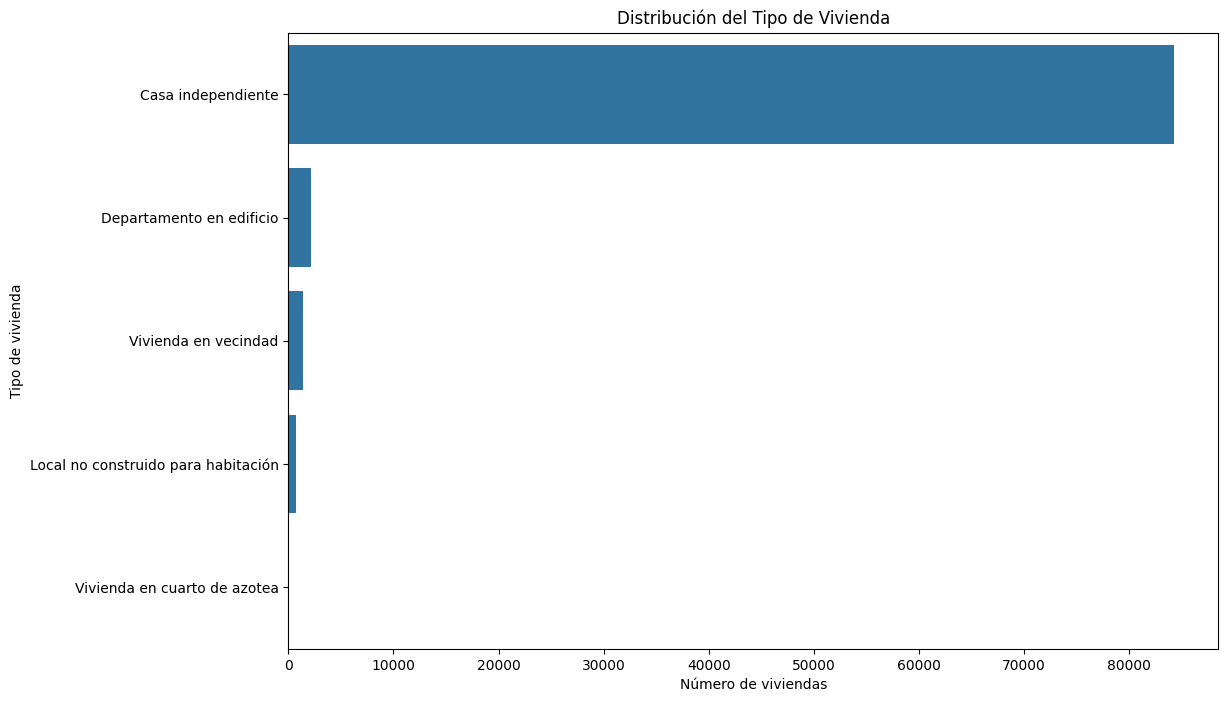

In [21]:
plt.figure(figsize=(12, 8))
sns.countplot(y='tipo_viv_desc', data=df_pd, order=df_pd['tipo_viv_desc'].value_counts().index)
plt.title('Distribución del Tipo de Vivienda')
plt.xlabel('Número de viviendas')
plt.ylabel('Tipo de vivienda')
plt.show()

### Grafica Material de Pared

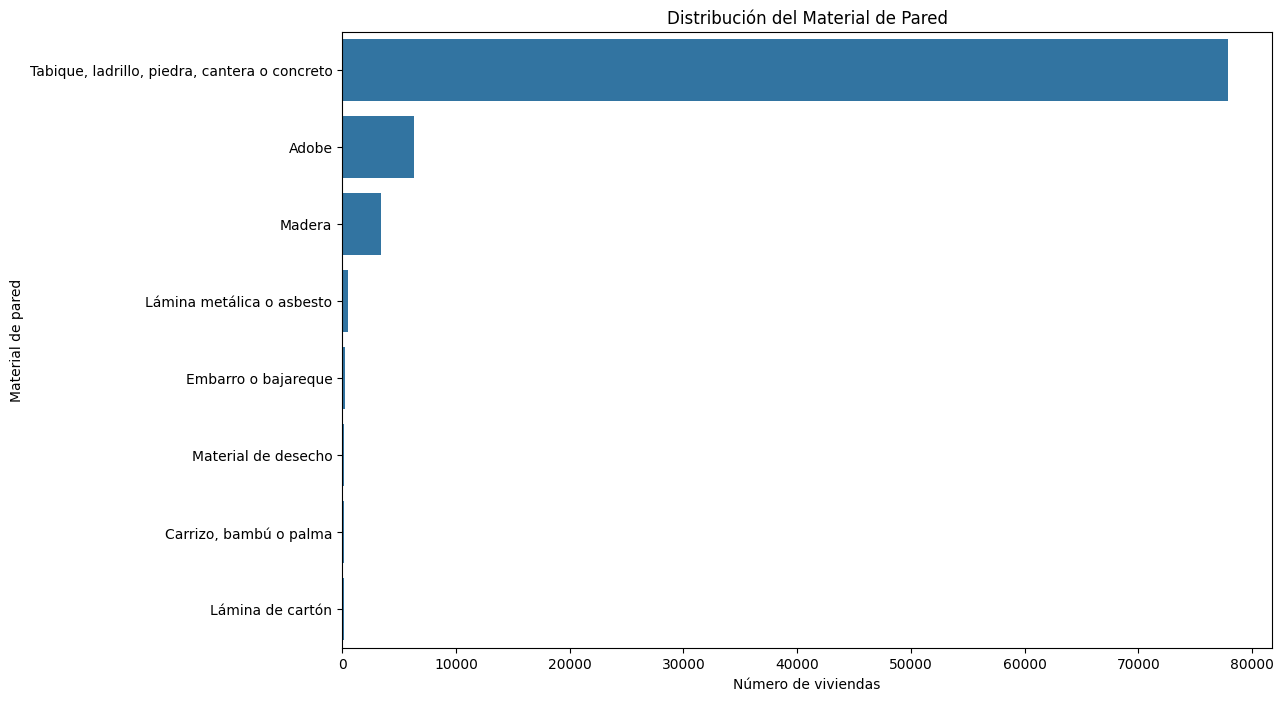

In [22]:
plt.figure(figsize=(12, 8))
sns.countplot(y='mat_pared_desc', data=df_pd, order=df_pd['mat_pared_desc'].value_counts().index)
plt.title('Distribución del Material de Pared')
plt.xlabel('Número de viviendas')
plt.ylabel('Material de pared')
plt.show()

### Grafica Material de techo

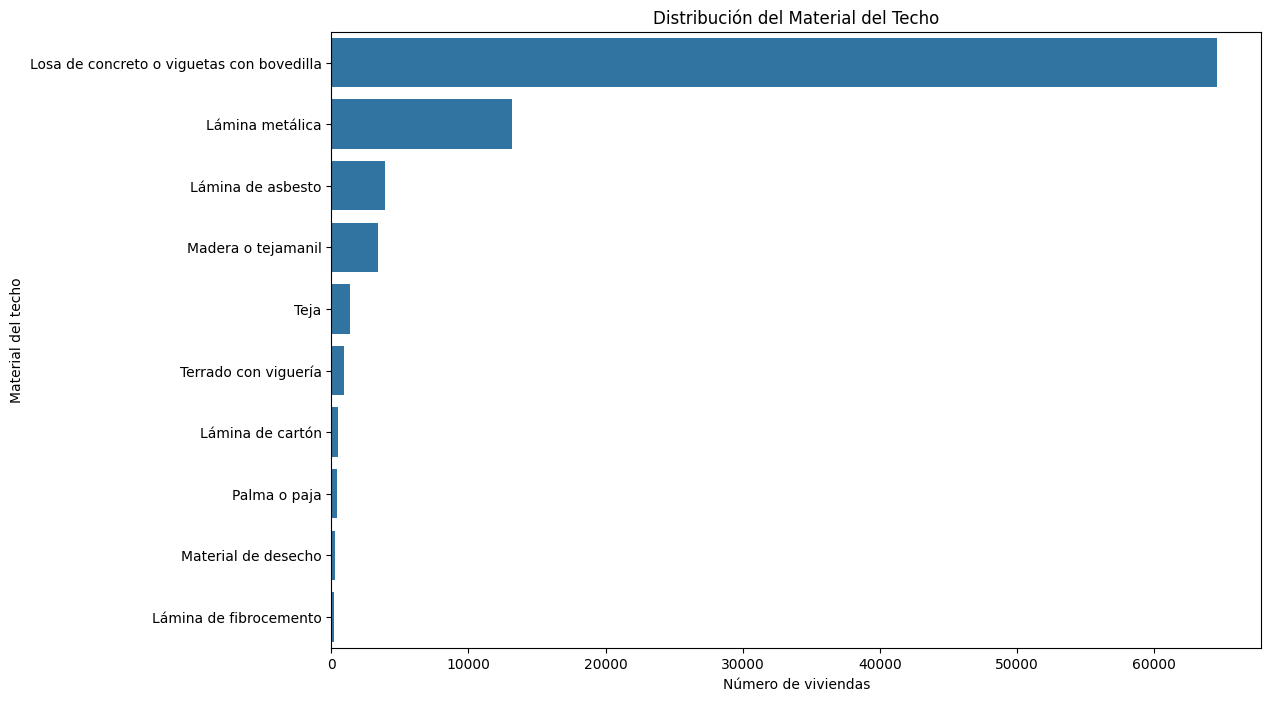

In [23]:
plt.figure(figsize=(12, 8))
sns.countplot(y='mat_techos_desc', data=df_pd, order=df_pd['mat_techos_desc'].value_counts().index)
plt.title('Distribución del Material del Techo')
plt.xlabel('Número de viviendas')
plt.ylabel('Material del techo')
plt.show()

### Grafico Material de piso

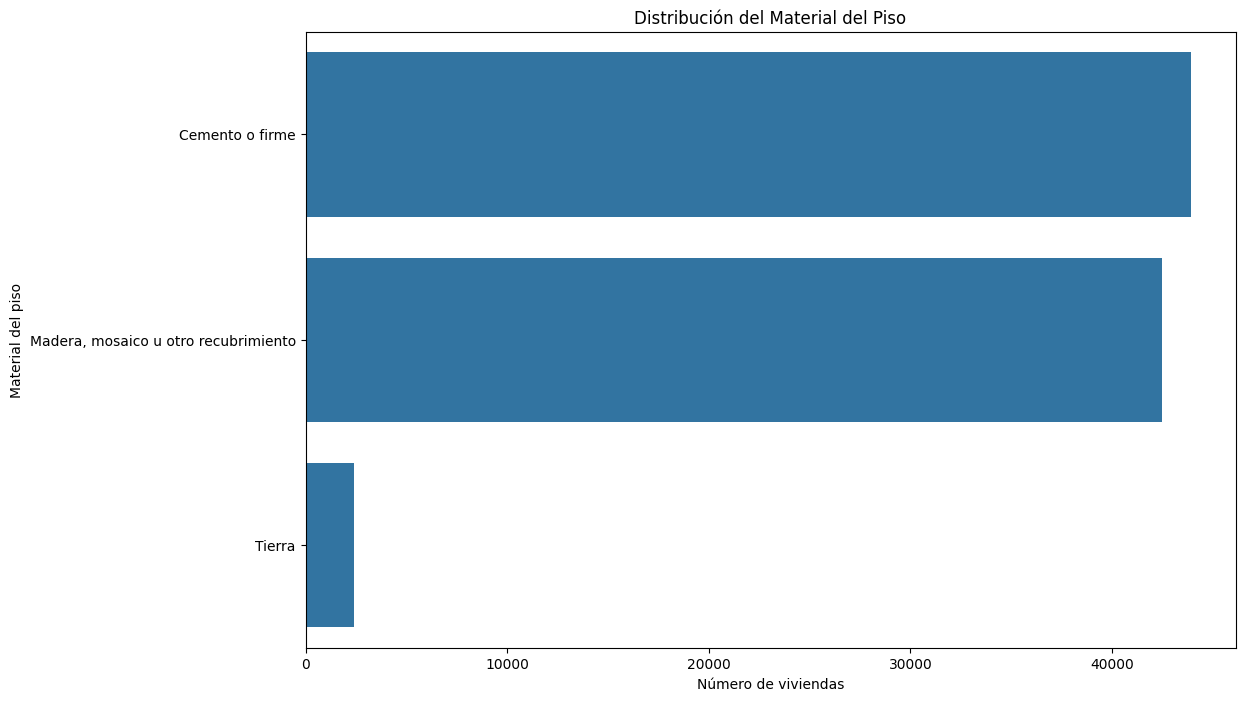

In [24]:
plt.figure(figsize=(12, 8))
sns.countplot(y='mat_pisos_desc', data=df_pd, order=df_pd['mat_pisos_desc'].value_counts().index)
plt.title('Distribución del Material del Piso')
plt.xlabel('Número de viviendas')
plt.ylabel('Material del piso')
plt.show()

### Grafico Disponibilidad de Agua

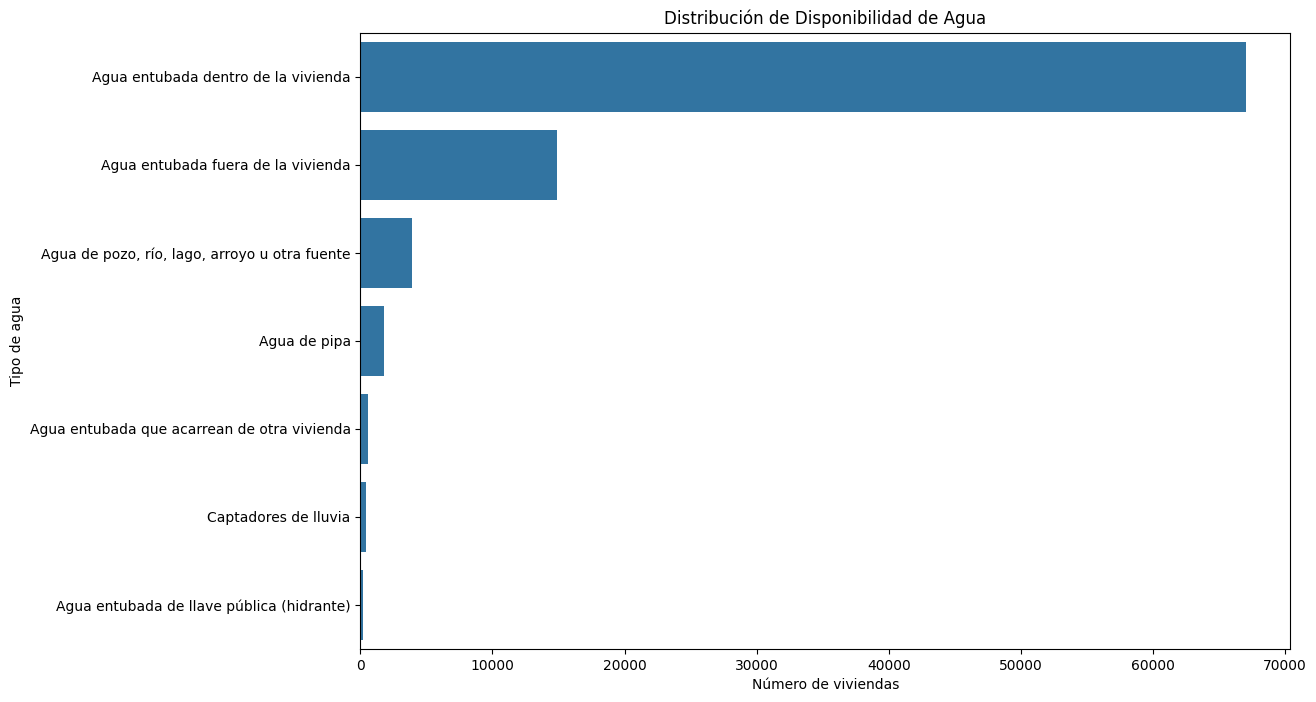

In [25]:
plt.figure(figsize=(12, 8))
sns.countplot(y='disp_agua_desc', data=df_pd, order=df_pd['disp_agua_desc'].value_counts().index)
plt.title('Distribución de Disponibilidad de Agua')
plt.xlabel('Número de viviendas')
plt.ylabel('Tipo de agua')
plt.show()

### Grafico Presencia de Sanitario

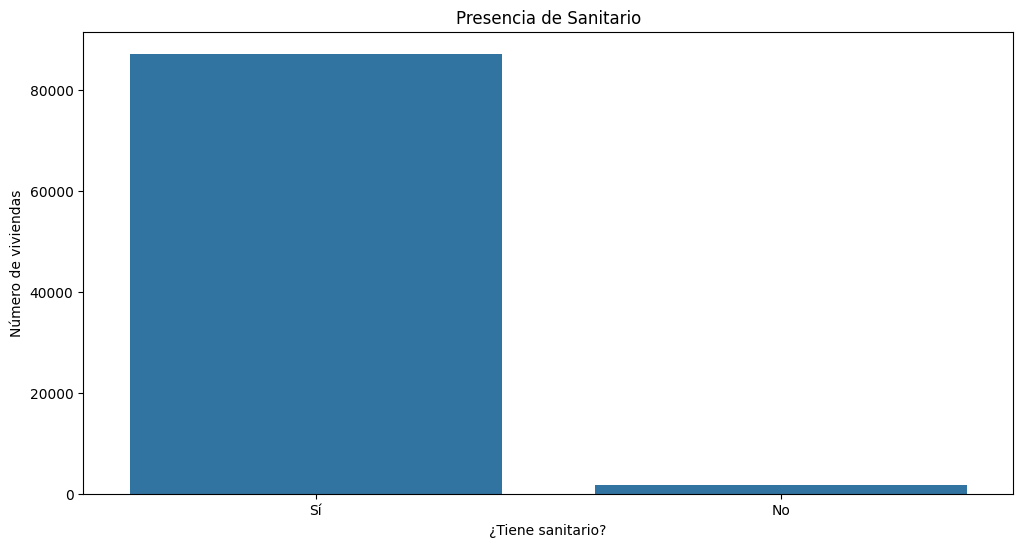

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(x='excusado_desc', data=df_pd, order=['Sí','No'])
plt.title('Presencia de Sanitario')
plt.xlabel('¿Tiene sanitario?')
plt.ylabel('Número de viviendas')
plt.show()

### Grafico distribucion tipo de drenaje

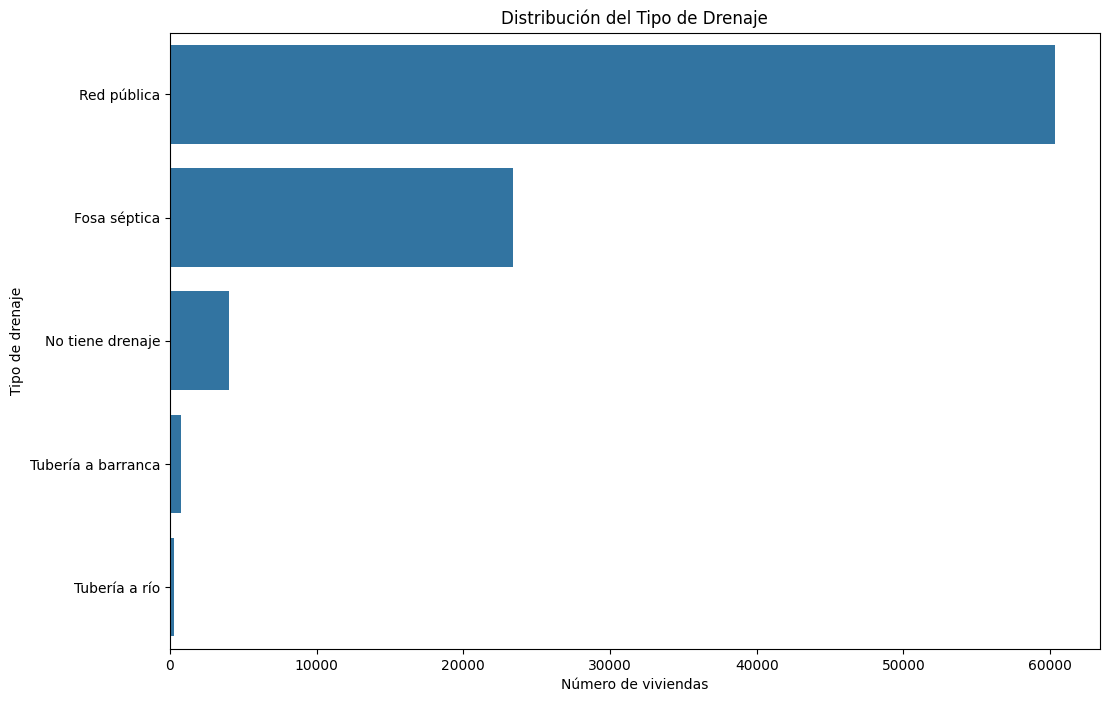

In [27]:
plt.figure(figsize=(12, 8))
sns.countplot(y='drenaje_desc', data=df_pd, order=df_pd['drenaje_desc'].value_counts().index)
plt.title('Distribución del Tipo de Drenaje')
plt.xlabel('Número de viviendas')
plt.ylabel('Tipo de drenaje')
plt.show()

### Grafico Tipo de suministro electrico

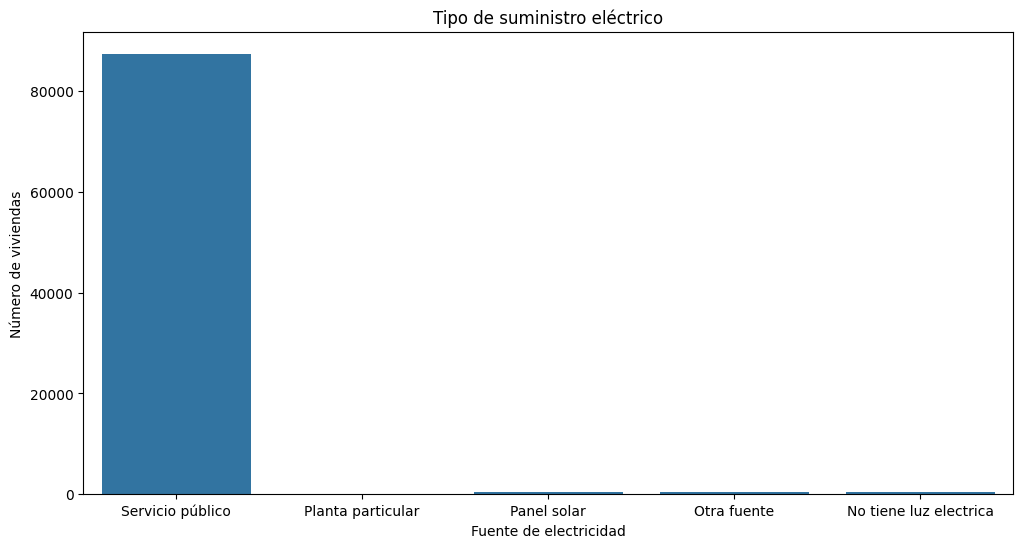

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(x='disp_elect_desc', data=df_pd, order=[
    'Servicio público', 'Planta particular', 'Panel solar', 'Otra fuente', 'No tiene luz electrica'])
plt.title('Tipo de suministro eléctrico')
plt.xlabel('Fuente de electricidad')
plt.ylabel('Número de viviendas')
plt.show()

### Grafico Frecuencia de Dotacion de Agua

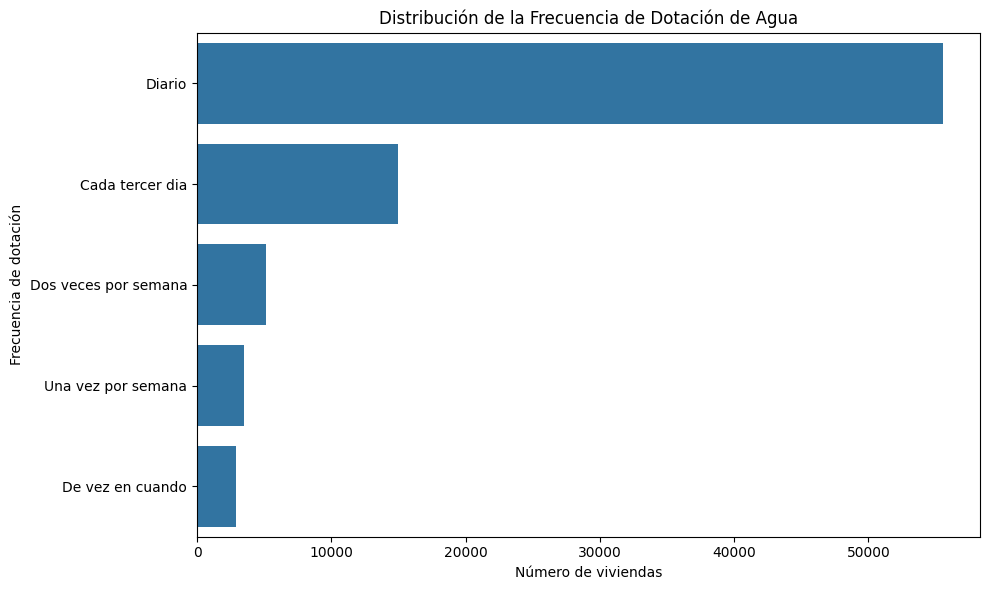

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(y='dotac_agua_desc', data=df_pd, order=df_pd['dotac_agua_desc'].value_counts().index)
plt.title('Distribución de la Frecuencia de Dotación de Agua')
plt.xlabel('Número de viviendas')
plt.ylabel('Frecuencia de dotación')
plt.tight_layout()
plt.show()

### Grafico Material de Pared segun tipo de vivienda

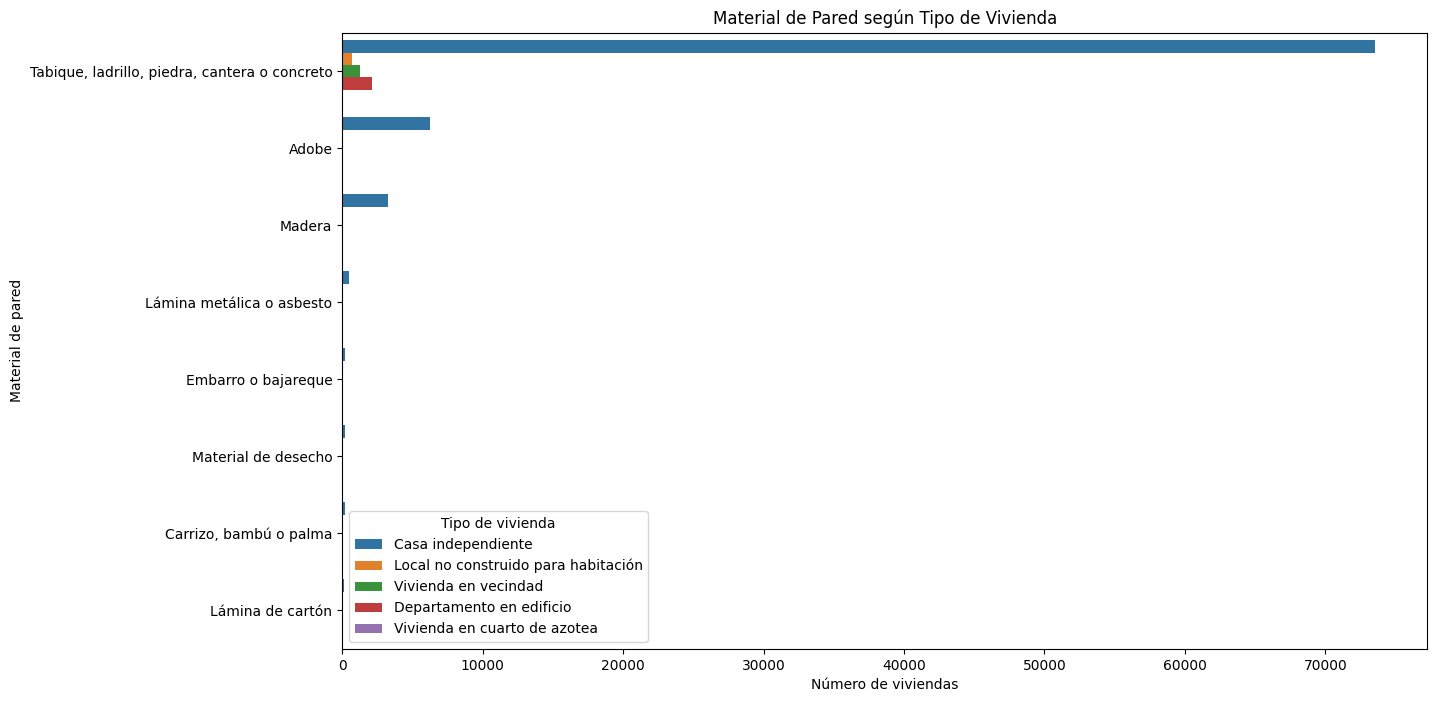

In [30]:
plt.figure(figsize=(14,8))
sns.countplot(data=df_pd, y='mat_pared_desc', hue='tipo_viv_desc',
              order=df_pd['mat_pared_desc'].value_counts().index)
plt.title('Material de Pared según Tipo de Vivienda')
plt.xlabel('Número de viviendas')
plt.ylabel('Material de pared')
plt.legend(title='Tipo de vivienda')
plt.show()

### Grafico material de techo segun tipo de vivienda

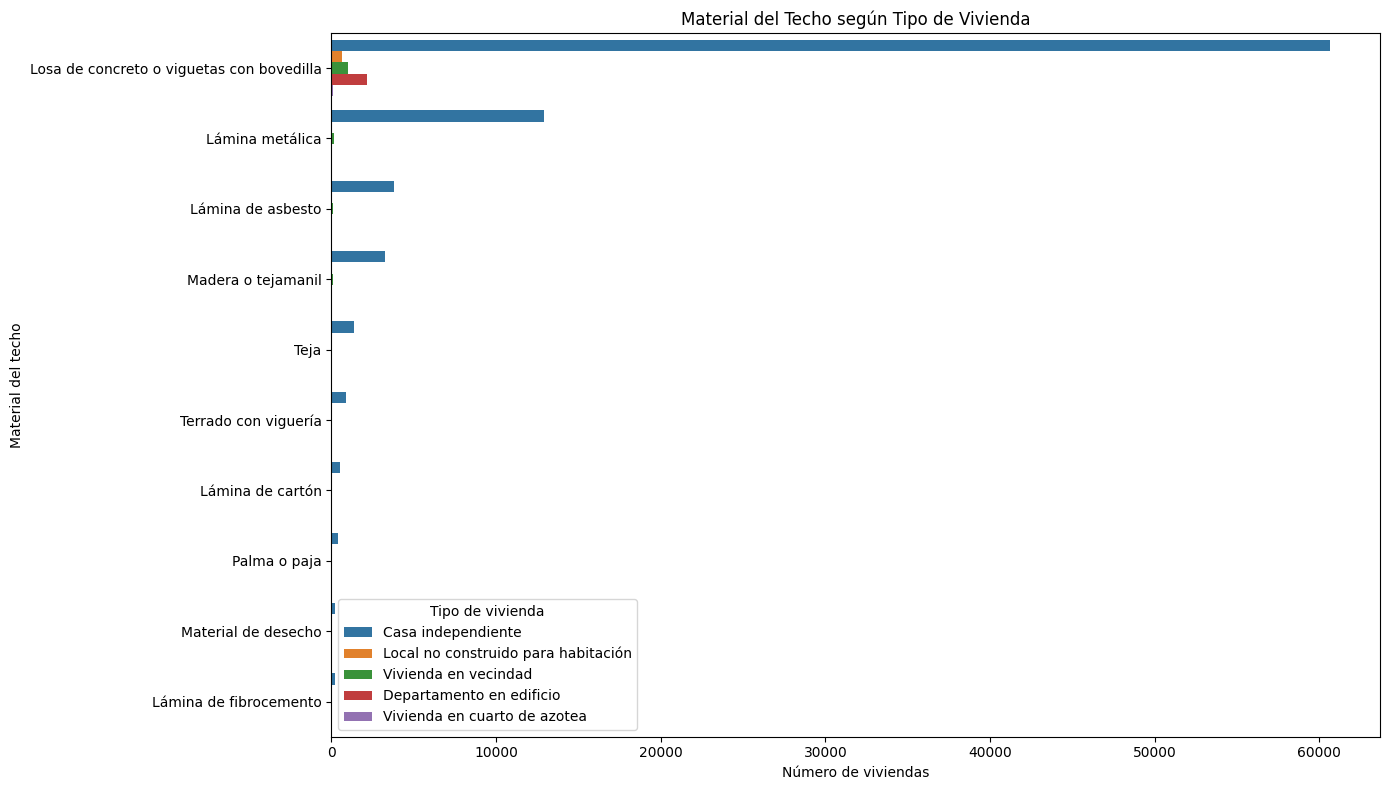

In [31]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df_pd, y='mat_techos_desc', hue='tipo_viv_desc',
              order=df_pd['mat_techos_desc'].value_counts().index)
plt.title('Material del Techo según Tipo de Vivienda')
plt.xlabel('Número de viviendas')
plt.ylabel('Material del techo')
plt.legend(title='Tipo de vivienda')
plt.tight_layout()
plt.show()

### Grafico Material de Piso segun tipo de vivienda

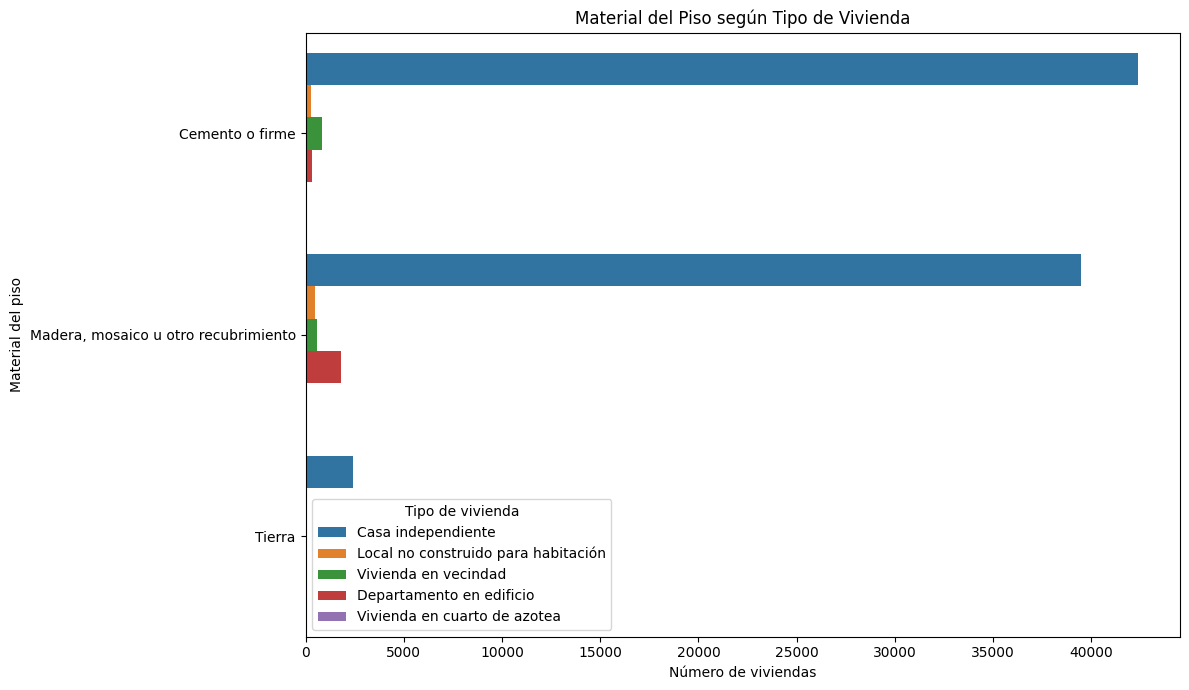

In [32]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df_pd, y='mat_pisos_desc', hue='tipo_viv_desc',
              order=df_pd['mat_pisos_desc'].value_counts().index)
plt.title('Material del Piso según Tipo de Vivienda')
plt.xlabel('Número de viviendas')
plt.ylabel('Material del piso')
plt.legend(title='Tipo de vivienda')
plt.tight_layout()
plt.show()

## 4. Preprocesamiento técnico (normalización, codificación, escalado, etc.)

Se preparan los datos para optimizar el desempeño de los modelos de ML

### Variable Objetivo: Carencia Hbaitacional

Se construyó una nueva variable llamada carencia_habitacional, que indica si una vivienda presenta malas condiciones . 
La variable se asigna con valor 1 (carencia) si se cumple al menos una de las siguientes condiciones:

Piso de tierra: el material del piso es tierra (mat_pisos == 1).

Sin excusado: la vivienda no cuenta con sanitario con excusado (excusado == 2).

Sin drenaje: la vivienda no tiene ningún tipo de drenaje (drenaje == 5).

Sin electricidad: no cuenta con luz eléctrica de ninguna fuente (disp_elect == 5).

Dotación de agua insuficiente: el agua llega cada tercer día o menos frecuentemente (dotac_agua en [2, 3, 4, 5]).

Agua no entubada: el agua proviene de fuentes alternativas como pozos, ríos o pipas (disp_agua no en [1, 2]).

Paredes precarias: hechas de materiales como desecho, lámina, embarro, madera, etc. (mat_pared en [1, 2, 3, 4, 5]).

Techo precario: cubierto por láminas, palma, paja o similares (mat_techos en [1, 2, 3, 4, 5, 6]).

Tipo de vivienda no habitable: como locales no construidos para vivienda (tipo_viv == 5).

Hacinamiento: menos de medio cuarto por persona en el hogar (cuartos_por_persona < 0.5).

La variable resultante carencia_habitacional toma el valor 1 si se cumple alguna de estas condiciones y 0 en caso contrario. 






In [33]:
df_pd["cuartos_por_persona"] = df_pd["num_cuarto"] / df_pd["tot_resid"]

cond_piso_tierra = df_pd['mat_pisos'] == 1
cond_sin_excusado = df_pd['excusado'] == 2
cond_sin_drenaje = df_pd['drenaje'] == 5
cond_sin_electricidad = df_pd['disp_elect'] == 5
cond_agua_baja_frec = df_pd['dotac_agua'].isin([2, 3, 4, 5])
cond_agua_no_entubada = ~df_pd['disp_agua'].isin([1, 2])
cond_pared_precaria = df_pd['mat_pared'].isin([1, 2, 3, 4, 5])
cond_techo_precario = df_pd['mat_techos'].isin([1, 2, 3, 4, 5, 6])
cond_tipo_viv_precaria = df_pd['tipo_viv'] == 5
cond_cuartos_persona = df_pd["cuartos_por_persona"] < 0.5  

cond_carencia = (
    cond_piso_tierra |
    cond_sin_excusado |
    cond_sin_drenaje |
    cond_sin_electricidad |
    cond_agua_baja_frec |
    cond_agua_no_entubada |
    cond_pared_precaria |
    cond_techo_precario |
    cond_tipo_viv_precaria |
    cond_cuartos_persona
)

df_pd['carencia_habitacional'] = np.where(cond_carencia, 1, 0)

### Conteo

Hacemos un primer conteo para ver cuantas viviendas tienen carencias

In [34]:
df_pd["carencia_habitacional"].value_counts()

carencia_habitacional
1    46267
0    42556
Name: count, dtype: int64

### Seleccion Variables

Se seleccionaron variables tanto numéricas como categóricas que permiten caracterizar las condiciones de la vivienda

In [35]:
variables_numericas = ['num_cuarto', 'tot_resid']
variables_categoricas = [
    'tipo_viv_desc',
    'mat_pared_desc',
    'mat_techos_desc',
    'mat_pisos_desc',
    'disp_agua_desc',
    'dotac_agua_desc',
    'excusado_desc',
    'drenaje_desc',
    'disp_elect_desc'
]

### Separacion variables

In [36]:
X = df_pd[variables_numericas + variables_categoricas]
y = df_pd['carencia_habitacional']

### Preprocesamiento de Datos

Se prepararon los datos para los algoritmos de clasificación, se aplicaron transformaciones específicas a los distintos tipos de variables

Se utilizó StandardScaler() para transformar las variables numéricas a una escala con media 0 y desviación estándar 1.

Asi mismo convertimos cada categoría en una nueva columna binaria (0 o 1)

In [37]:
transformador_numerico = StandardScaler()
transformador_categorico = OneHotEncoder(handle_unknown='ignore')

preprocesador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, variables_numericas),
        ('cat', transformador_categorico, variables_categoricas)
    ]
)

X_preprocesado = preprocesador.fit_transform(X)

## 5. Entrenamiento del modelo ML

### Division

Se dividió el conjunto de datos en datos de entrenamiento y datos de prueba para evaluar el desempeño 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

## Random Forest

Para la predicción de carencia habitacional, se implementó un modelo de clasificación utilizando Random Forest. Se construyó un Pipeline para automatizar el flujo de trabajo, desde el preprocesamiento de los datos hasta la predicción

In [39]:
modelo_rf = RandomForestClassifier(
    n_estimators=100,   
    max_depth=None,     
    random_state=42
)

pipeline_rf = Pipeline(steps=[
    ('preprocesamiento', preprocesador),  
    ('modelo', modelo_rf)
])

pipeline_rf.fit(X_train, y_train)

y_pred = pipeline_rf.predict(X_test)

## 6. Evaluacion del modelo

### Predicciones

In [40]:
y_pred = pipeline_rf.predict(X_test)
y_proba = pipeline_rf.predict_proba(X_test)[:, 1]

### Estadisticas

Podemos ver que obtuvimos execelentes valores en todos los campos, obteniendo en todos 0.99, esto nos indica que el modelo funciona bastante bien para detectar tanto si hay carencia o no

In [41]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.9983487822268924
Precision: 0.9995667244367418
Recall: 0.9972622478386167
F1 Score: 0.9984131563762262
ROC AUC: 0.999993197181404


In [42]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12767
           1       1.00      1.00      1.00     13880

    accuracy                           1.00     26647
   macro avg       1.00      1.00      1.00     26647
weighted avg       1.00      1.00      1.00     26647



### Matriz de Confusion

Aqui podemos observar como se detectan la mayoria de los cosas en donde si hay carencia o donde no

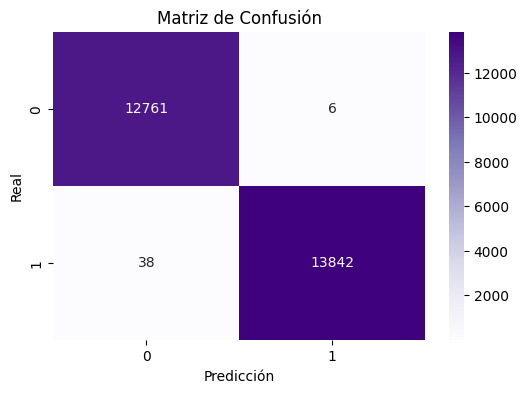

In [43]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

### Curva ROC

Al tener un AUC = 1, podemos decir que el modelo tiene un gran desempeño, tanto para los casos positivos como para los negativos

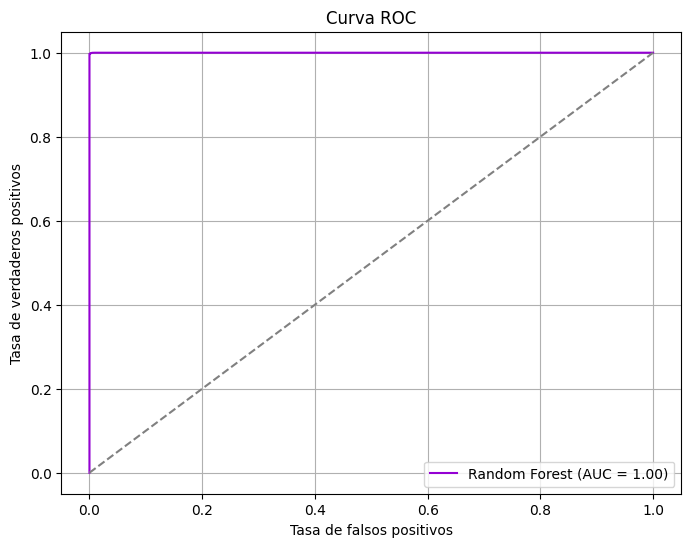

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba):.2f})", color='darkviolet')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

## 7. Visualizacion de resultado y metricas

### Matriz de Confusion

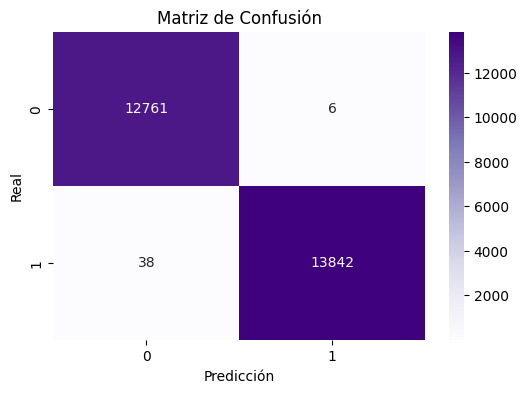

In [45]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

### Curva ROC

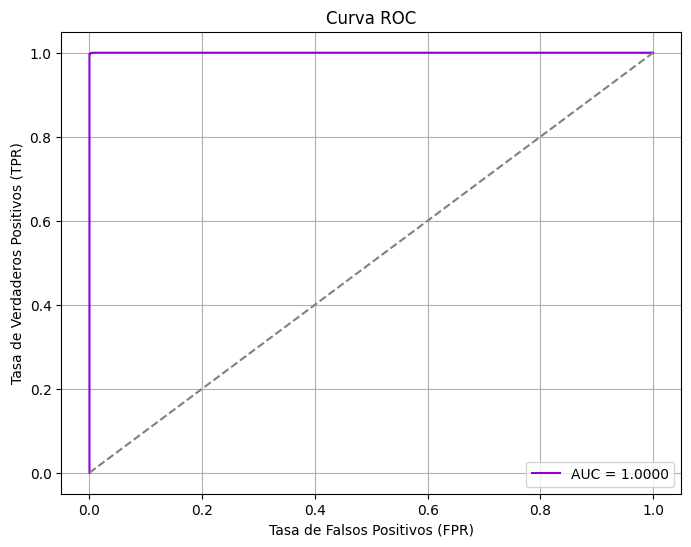

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}", color='darkviolet')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

### Distribucion de Carencia Habitacional

C:\Users\camil\AppData\Local\Temp\ipykernel_10696\60753530.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='carencia_habitacional', data=df_pd, palette='pastel')


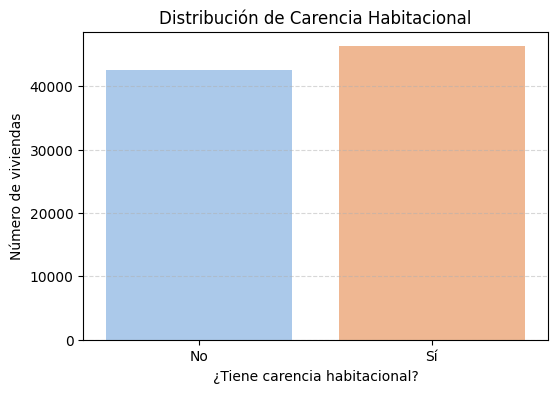

In [47]:
plt.figure(figsize=(6,4))
sns.countplot(x='carencia_habitacional', data=df_pd, palette='pastel')
plt.title('Distribución de Carencia Habitacional')
plt.xlabel('¿Tiene carencia habitacional?')
plt.ylabel('Número de viviendas')
plt.xticks([0,1], ['No', 'Sí'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### Disponibilidad de agu por condicion de carencia

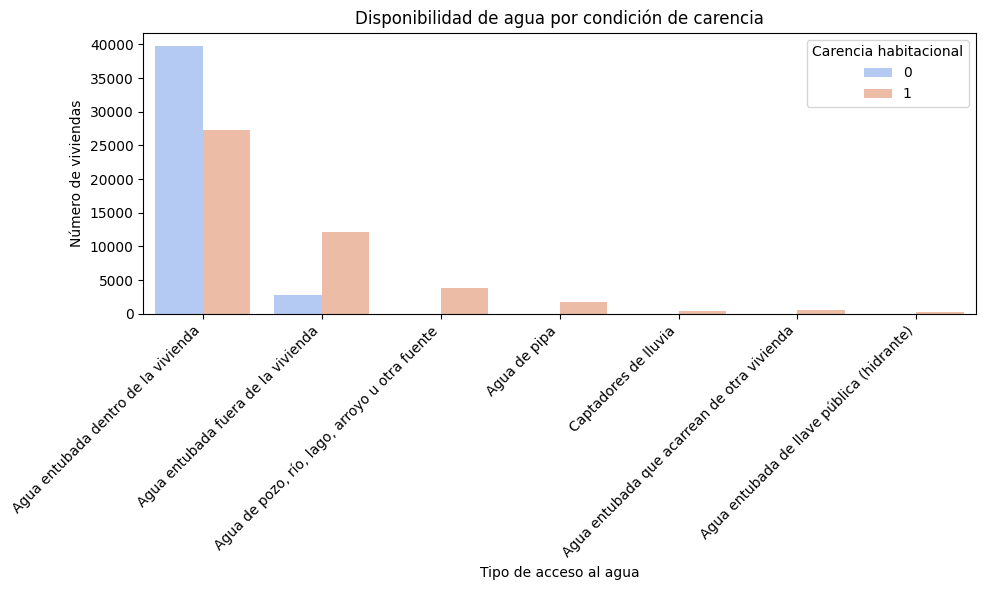

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(x='disp_agua_desc', hue='carencia_habitacional', data=df_pd, palette='coolwarm')
plt.title('Disponibilidad de agua por condición de carencia')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Tipo de acceso al agua')
plt.ylabel('Número de viviendas')
plt.legend(title='Carencia habitacional')
plt.tight_layout()
plt.show()

### Tipo de Drenaje y carencia habitacional

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='drenaje_desc', hue='carencia_habitacional', data=df_pd, palette='Set2')
plt.title('Tipo de drenaje y carencia habitacional')
plt.xlabel('Tipo de drenaje')
plt.ylabel('Número de viviendas')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Carencia habitacional')
plt.show()

### Disponibilidad de electricidad y carencia

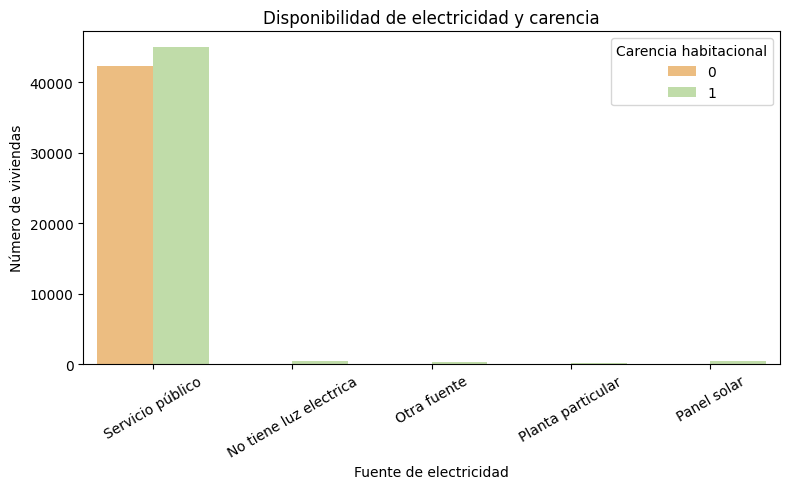

In [49]:
plt.figure(figsize=(8, 5))
sns.countplot(x='disp_elect_desc', hue='carencia_habitacional', data=df_pd, palette='Spectral')
plt.title('Disponibilidad de electricidad y carencia')
plt.xlabel('Fuente de electricidad')
plt.ylabel('Número de viviendas')
plt.xticks(rotation=30)
plt.legend(title='Carencia habitacional')
plt.tight_layout()
plt.show()

### Distribucion de Cuartos por persona

C:\Users\camil\AppData\Local\Temp\ipykernel_10696\2351125423.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='carencia_habitacional', y='cuartos_por_persona', data=df_pd, palette='Set3')


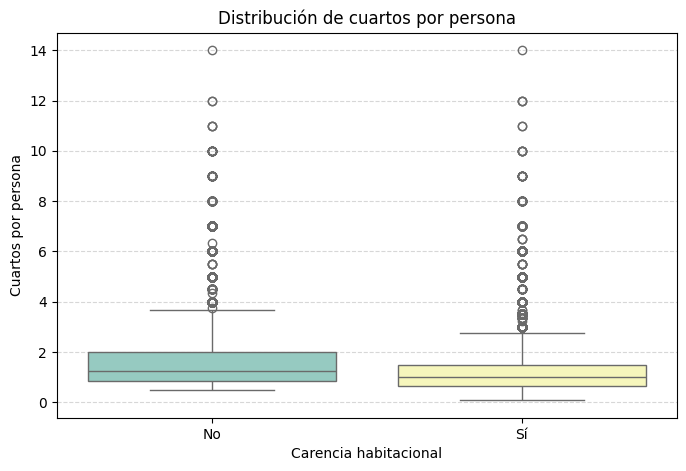

In [50]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='carencia_habitacional', y='cuartos_por_persona', data=df_pd, palette='Set3')
plt.title('Distribución de cuartos por persona')
plt.xlabel('Carencia habitacional')
plt.ylabel('Cuartos por persona')
plt.xticks([0,1], ['No', 'Sí'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()